### purpose

validate outlier offset

### notes

RONA (and to some extent LFMM) are doing worse than GF and RDA, so figures that are made across programs should keep this in imind

In [1]:
from pythonimports import *
from myfigs import adjust_box_widths

import MVP_00_start_pipeline as mvp00
import MVP_10_train_lfmm2_offset as mvp10
import MVP_summary_functions as mvp

import seaborn as sns

t1 = dt.now()  # notebook timer

envdir = '/home/b.lind/offsets/climate_outlier_runs/garden_files'
fitness_dir = '/home/b.lind/offsets/climate_outlier_runs/fitness_mats'

lview, dview = get_client(cluster_id='1678802138-e7iz', profile='lotterhos')

mvp.latest_commit()
session_info.show()

36 36
#########################################################
Today:	March 14, 2023 - 13:53:05
python version: 3.8.5

Current commit of pythonimports:
commit 8d4f83fd91caa2e58acbafcadfde07d19ae79379  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Fri Mar 3 00:48:36 2023 -0500

Current commit of MVP_offsets:
commit 11296c5e9cb778ba1aebb1c2ff0e5f499bf6f646  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Mon Mar 13 14:39:28 2023 -0400
#########################################################



In [2]:
climdir = '/home/b.lind/offsets/climate_outlier_runs'

clim_rundirs = fs(climdir, startswith='run', dirs=True)

clim_rundirs

['/home/b.lind/offsets/climate_outlier_runs/run_20220919_0-225',
 '/home/b.lind/offsets/climate_outlier_runs/run_20220919_1125-1350',
 '/home/b.lind/offsets/climate_outlier_runs/run_20220919_225-450',
 '/home/b.lind/offsets/climate_outlier_runs/run_20220919_450-675',
 '/home/b.lind/offsets/climate_outlier_runs/run_20220919_675-900',
 '/home/b.lind/offsets/climate_outlier_runs/run_20220919_900-1125']

In [3]:
seeds = mvp00.get_seeds(mvp.slimdir)

len(seeds)

2250

# retrieve validations

In [4]:
validations = []
for d in pbar(clim_rundirs):
    run = op.basename(d)
    for program in ['GF', 'lfmm2', 'rda', 'RONA']:
        f = op.join(d, f'{program}/validation/climate_outlier_validation_scores.txt')
        
        if op.exists(f):
            df = pd.read_table(f).copy()
                
            if program == 'RONA':
                dfs = []
                for env in ['sal_opt', 'temp_opt']:
                    x = df[df.env==env].copy()
                    x['program'] = f'RONA-{env}'
                    dfs.append(x)
                df = pd.concat(dfs)
            
            if program != 'RONA':
                assert len(df['program'].unique()) == 1
                assert df['program'].iloc[0] == program
            else:
                assert len(df['program'].unique()) == 2
                assert all(df.program.str.contains(program))
                
            
            validations.append(df)
            
        else:
            print(f)
        
validation = pd.concat(validations)

bcs_validation = mvp.get_bcs_dataframe(validation)

validation.head()

 67%|██████████     | 4/6 [00:01<00:00,  2.45it/s]

/home/b.lind/offsets/climate_outlier_runs/run_20220919_675-900/lfmm2/validation/climate_outlier_validation_scores.txt


100%|███████████████| 6/6 [00:02<00:00,  2.78it/s]


/home/b.lind/offsets/climate_outlier_runs/run_20220919_900-1125/GF/validation/climate_outlier_validation_scores.txt
/home/b.lind/offsets/climate_outlier_runs/run_20220919_900-1125/lfmm2/validation/climate_outlier_validation_scores.txt
/home/b.lind/offsets/climate_outlier_runs/run_20220919_900-1125/RONA/validation/climate_outlier_validation_scores.txt


seed marker_set program  outlier_clim     score block            glevel  \
0  1231094   adaptive      GF          0.00 -0.780956   all  highly-polygenic   
1  1231094   adaptive      GF          1.10 -0.915925   all  highly-polygenic   
2  1231094   adaptive      GF          1.50 -0.872813   all  highly-polygenic   
3  1231094   adaptive      GF          1.75 -0.827631   all  highly-polygenic   
4  1231094   adaptive      GF          2.00 -0.757272   all  highly-polygenic   

    plevel          pleio slevel   landscape                 popsize  \
0  1-trait  no pleiotropy    NaN  Est-Clines  N-cline-center-to-edge   
1  1-trait  no pleiotropy    NaN  Est-Clines  N-cline-center-to-edge   
2  1-trait  no pleiotropy    NaN  Est-Clines  N-cline-center-to-edge   
3  1-trait  no pleiotropy    NaN  Est-Clines  N-cline-center-to-edge   
4  1-trait  no pleiotropy    NaN  Est-Clines  N-cline-center-to-edge   

    migration ntraits ind_or_pooled use_RDA_outliers structcorr  outlier_val  \
0  m-constant     NaN           NaN              NaN        NaN          NaN   
1  m-constant     NaN           NaN              NaN        NaN          NaN   
2  m-constant     NaN           NaN              NaN        NaN          NaN   
3  m-constant     NaN           NaN              NaN        NaN          NaN   
4  m-constant     NaN           NaN              NaN        NaN          NaN   

   env  
0  NaN  
1  NaN  
2  NaN  
3  NaN  
4  NaN

# all programs together - use 100 pops to validate outlier clims

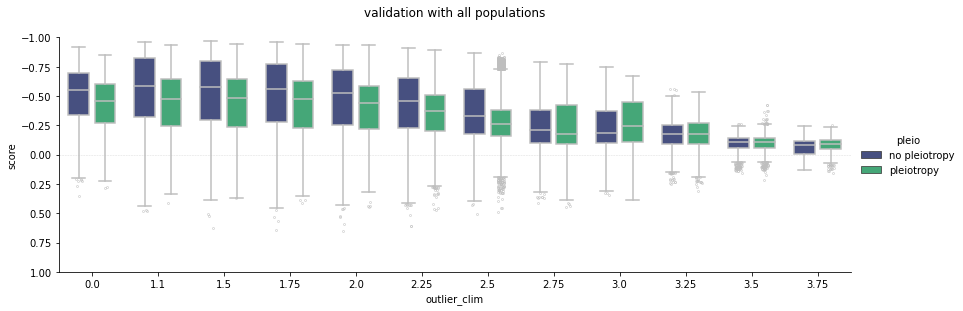

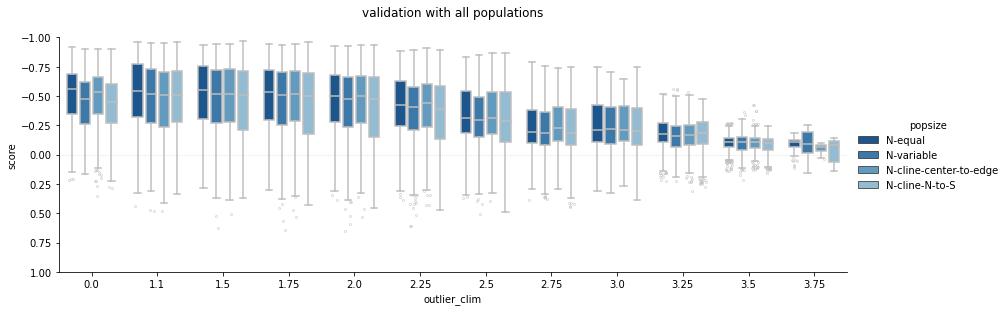

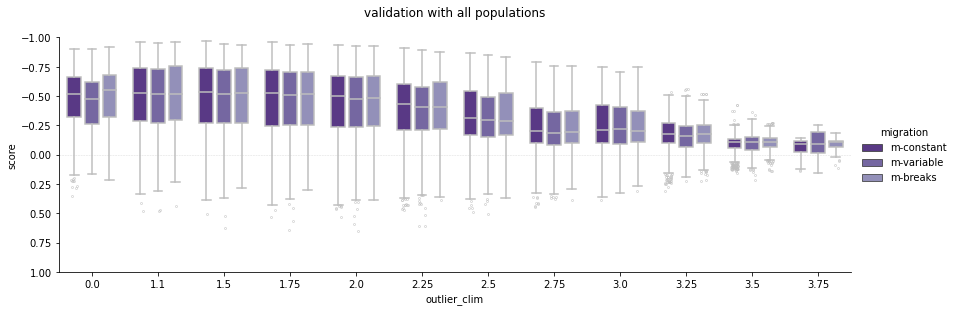

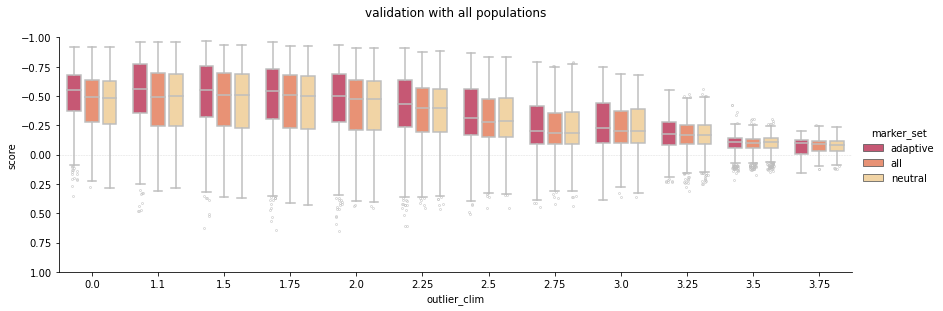

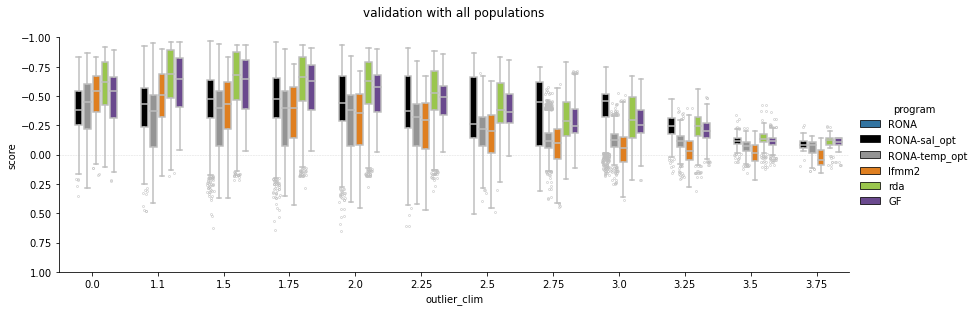

In [5]:
for hue, horder in mvp.hue_order.items():
    if hue == 'noncausal_env':
        continue

    g = sns.catplot(data=validation[validation.block=='all'],
                    x='outlier_clim',
                    y='score',
                    order=[0.0, 1.1, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75], #['1.1', '1.25', '1.5', '2.0', '4.0', '6.0', '8.0', '10.0'],
                    kind='box',
                    hue=hue,
                    hue_order=horder,
                    **mvp.boxplot_kwargs,
                    height=4,
                    aspect=3,
                   )

    adjust_box_widths(list(g.axes[0]), 0.8)
    mvp.jitter_fliers(g)
    
    g.set(ylim=(1, -1),
          title='all data\nvalidation with all populations\n')
    
    for ax in g.axes[0]:
        ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)
        
    plt.show()


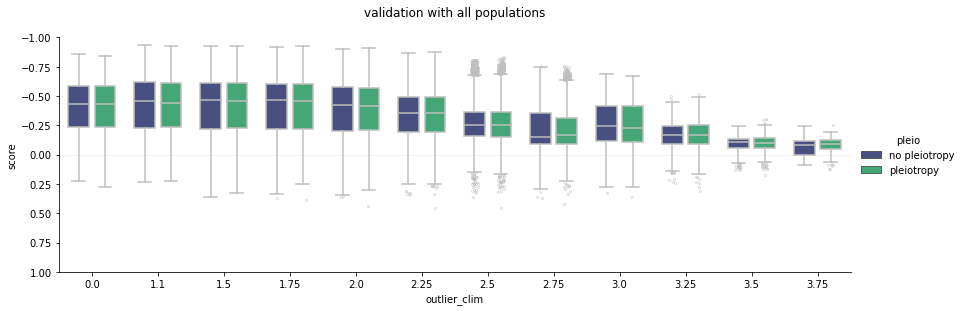

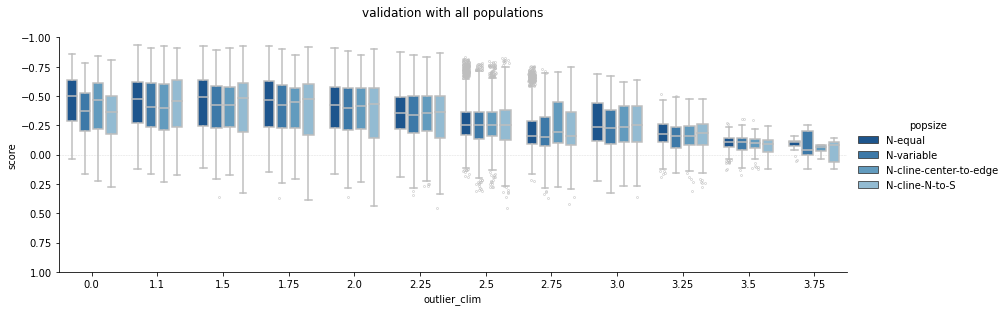

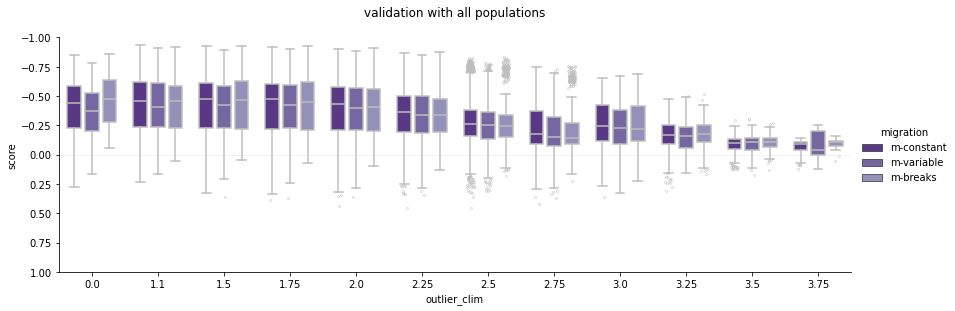

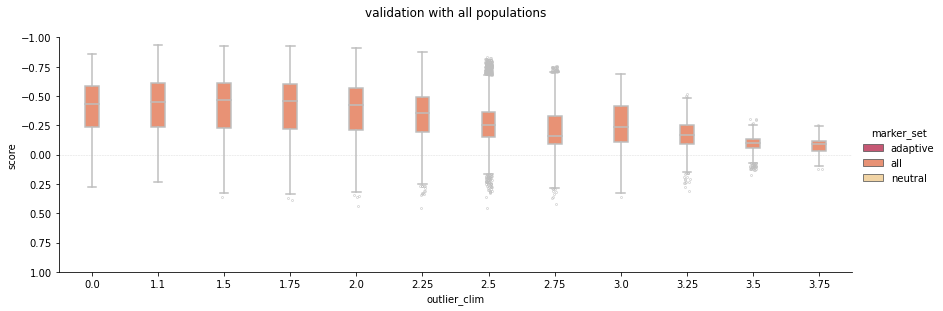

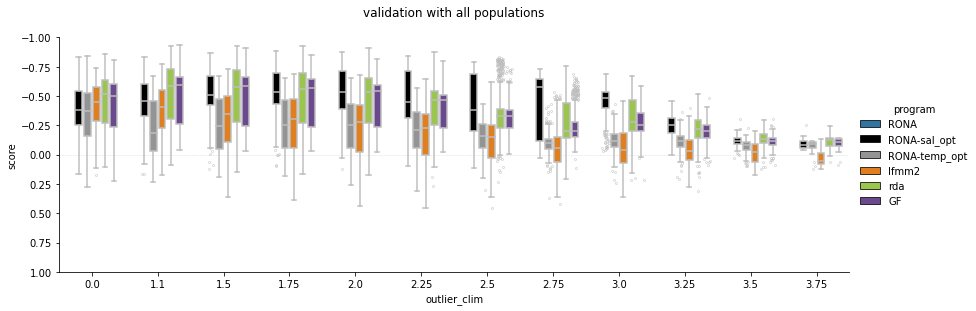

In [6]:
# same fig but bcs data
for hue, horder in mvp.hue_order.items():
    if hue == 'noncausal_env':
        continue

    g = sns.catplot(data=bcs_validation[bcs_validation.block=='all'],
                    x='outlier_clim',
                    y='score',
                    order=[0.0, 1.1, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75], #['1.1', '1.25', '1.5', '2.0', '4.0', '6.0', '8.0', '10.0'],
                    kind='box',
                    hue=hue,
                    hue_order=horder,
                    **mvp.boxplot_kwargs,
                    height=4,
                    aspect=3,
                   )

    adjust_box_widths(list(g.axes[0]), 0.8)
    mvp.jitter_fliers(g)
    
    g.set(ylim=(1, -1),
          title='BCS data\nvalidation with all populations\n')
    
    for ax in g.axes[0]:
        ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)
        
    plt.show()


# separate programs

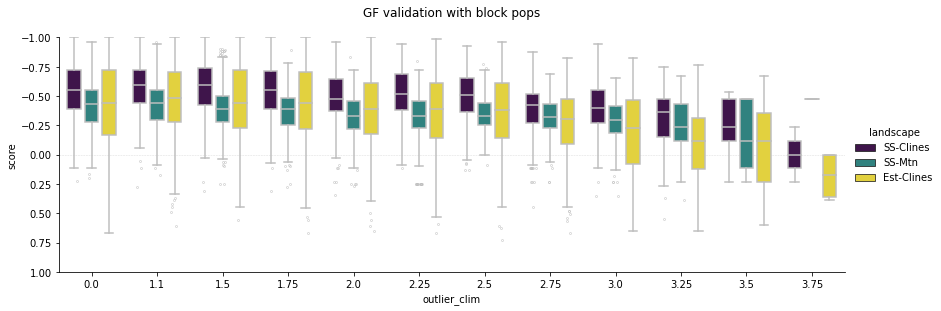

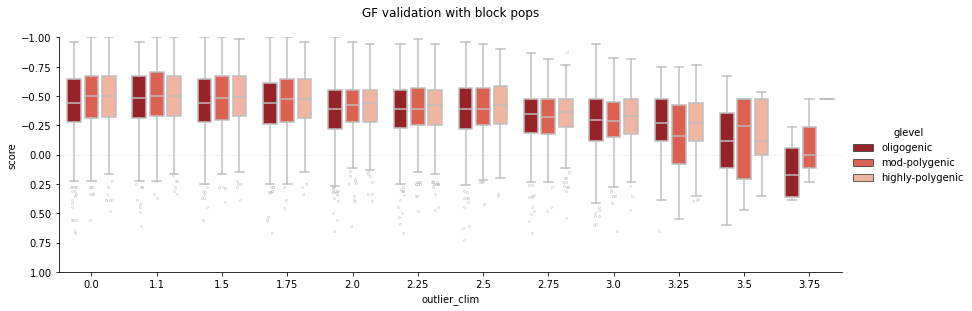

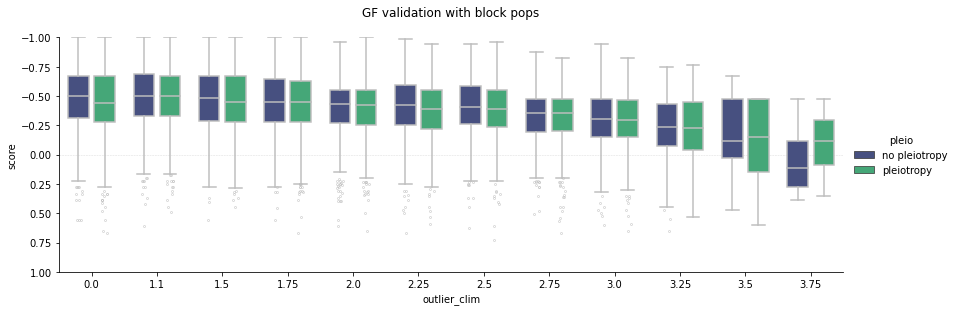

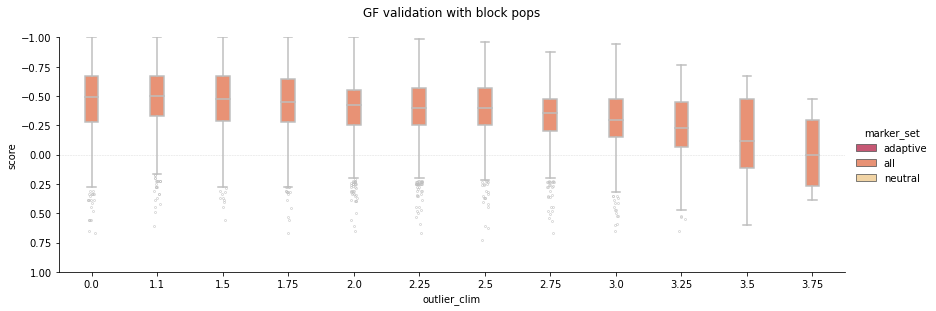

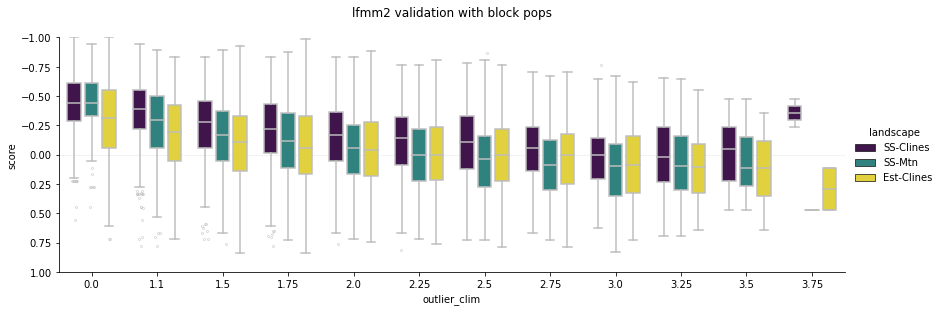

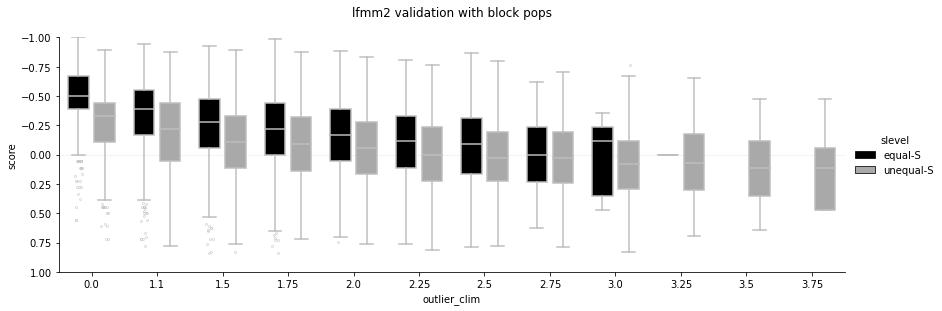

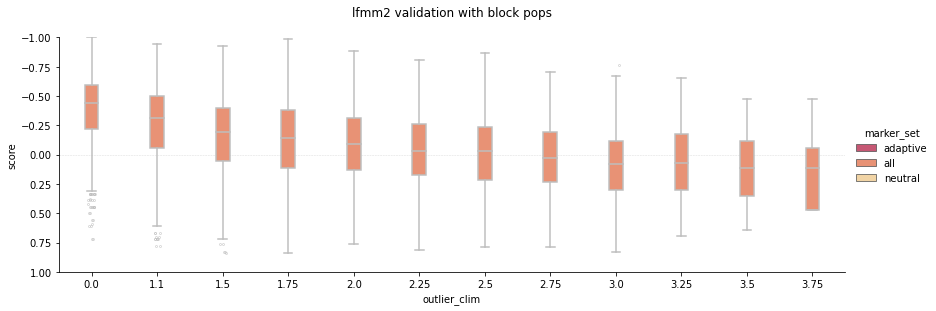

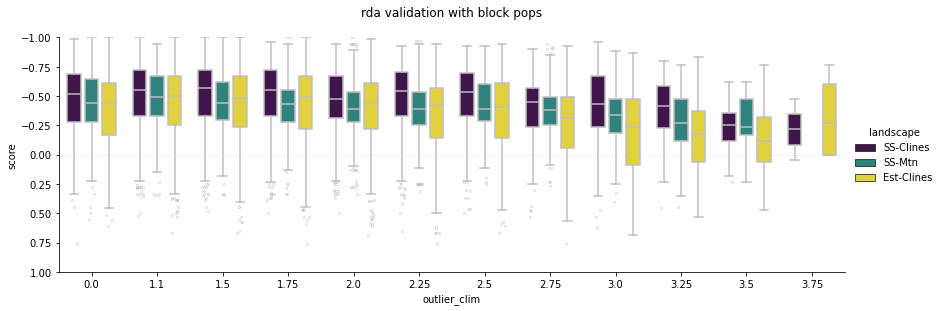

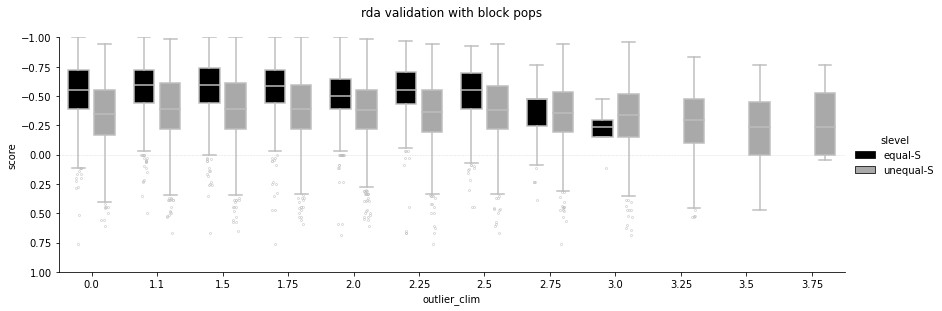

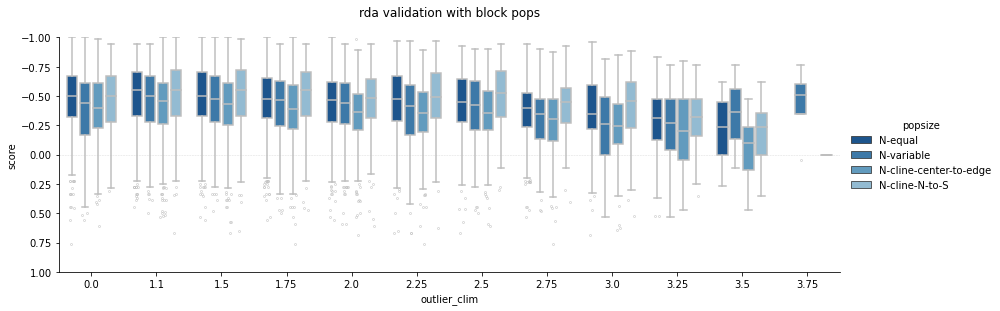

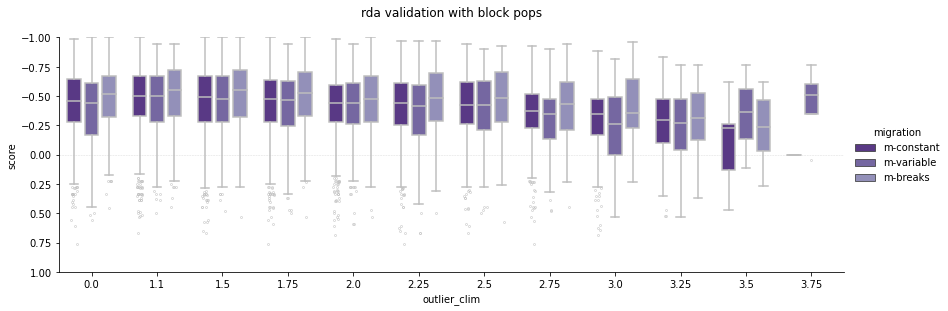

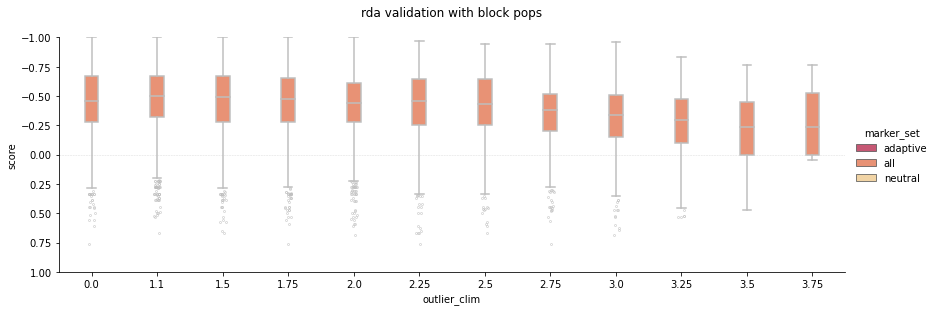

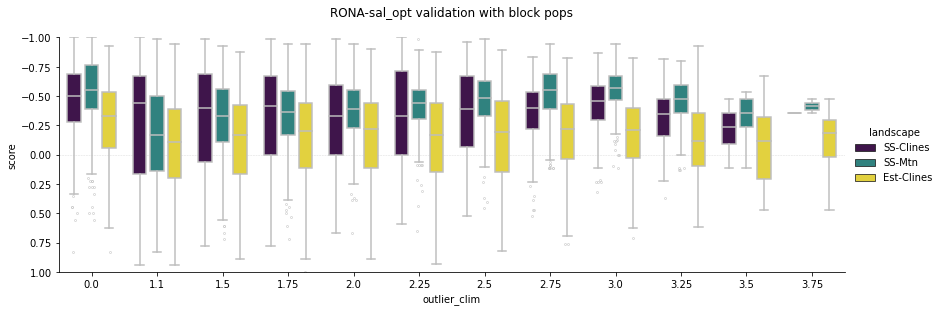

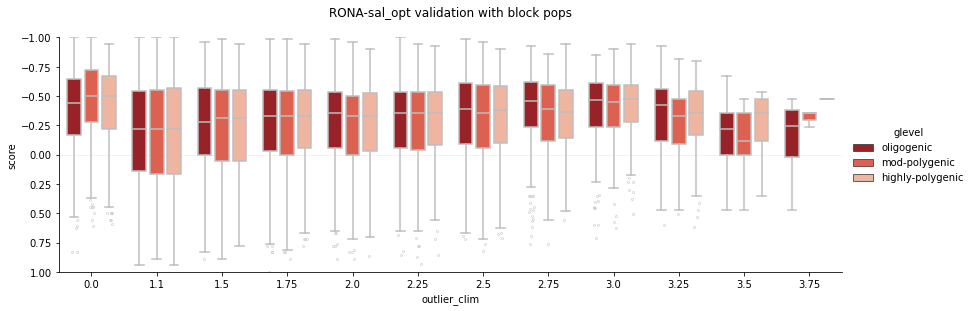

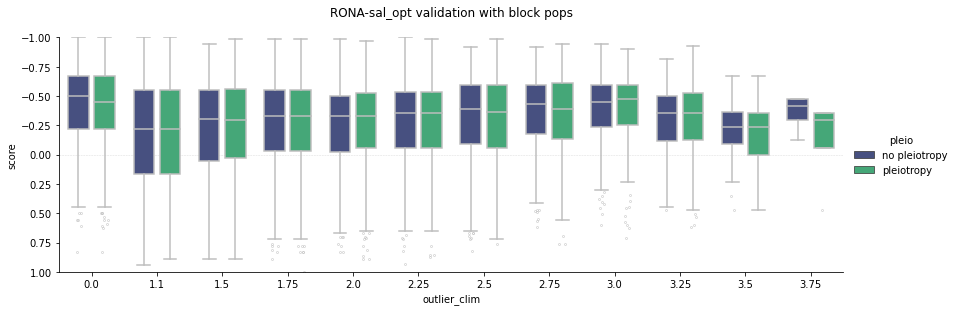

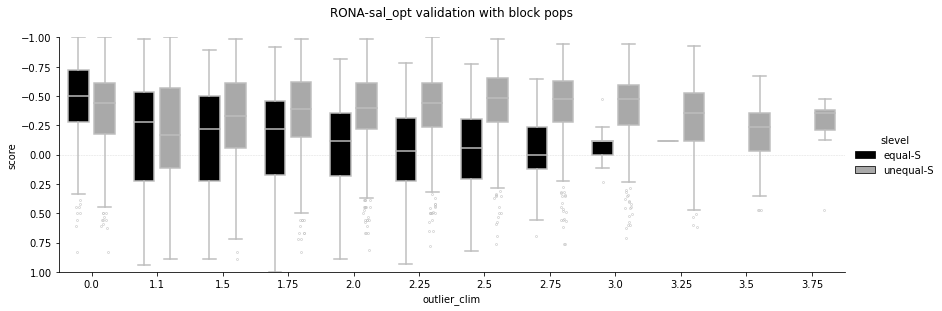

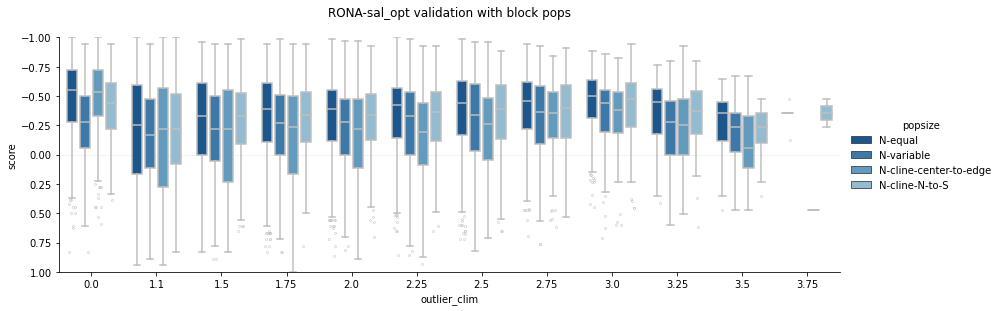

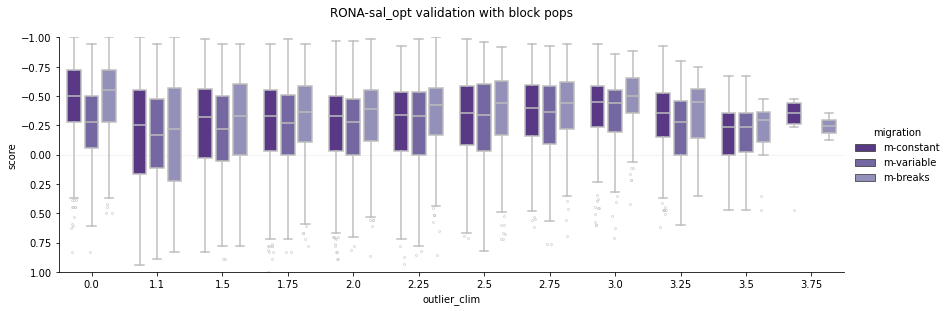

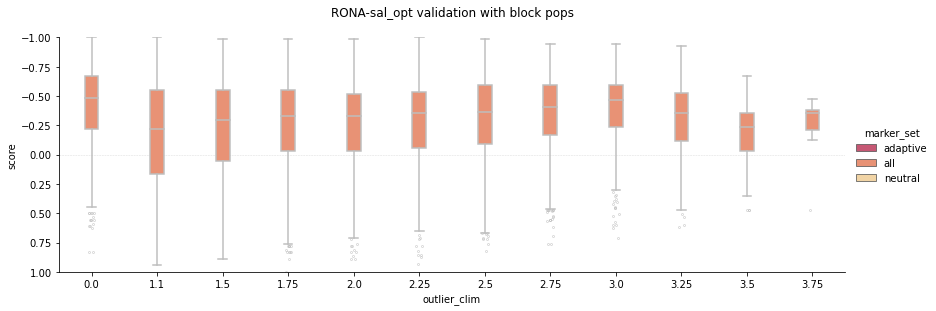

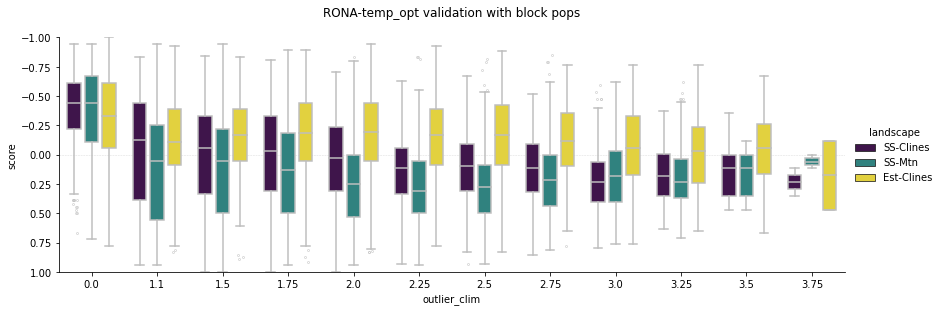

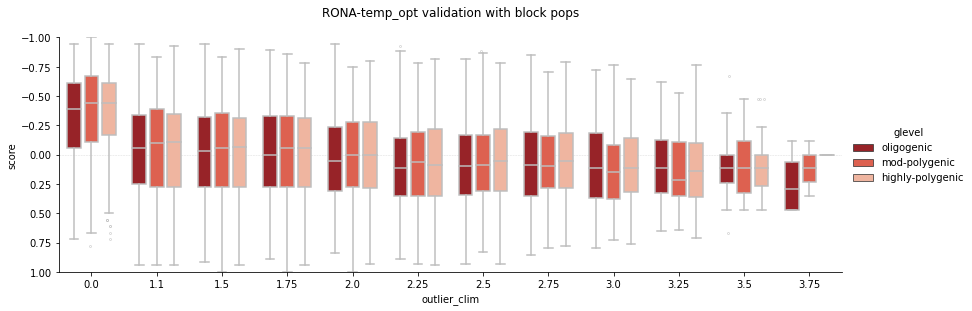

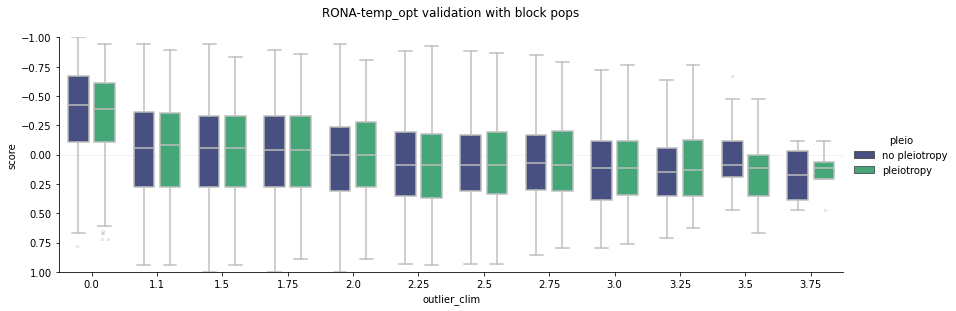

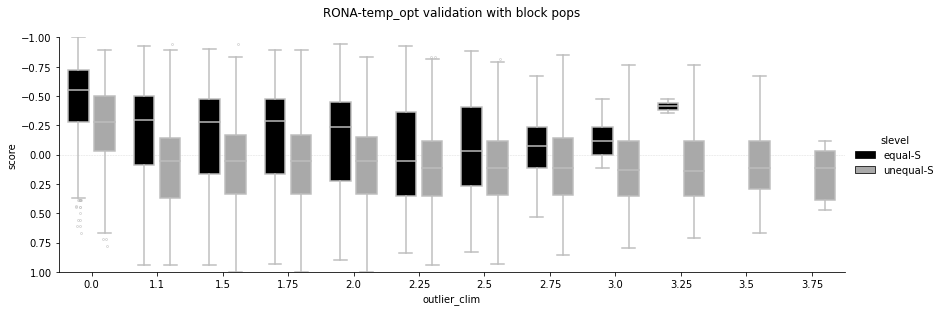

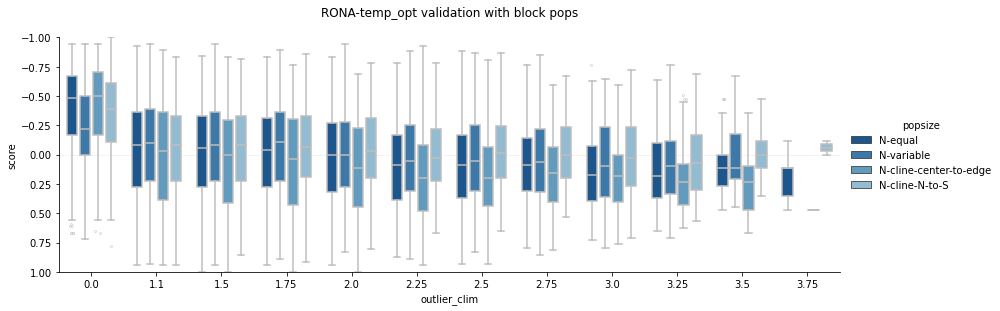

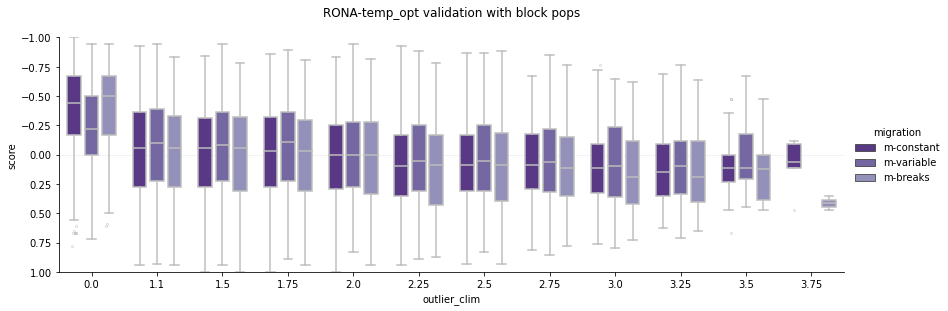

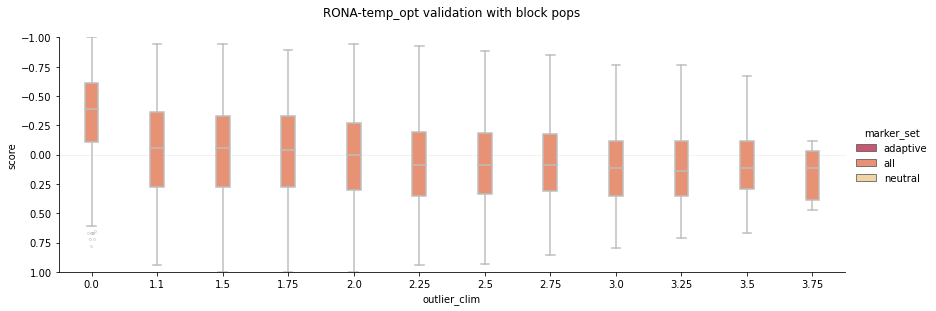

In [6]:
for program in validation.program.unique():
    for hue, horder in mvp.hue_order.items():
        if hue == 'noncausal_env' or hue == 'program':
            continue

        g = sns.catplot(data=validation[(validation.block!='all') & (validation.program==program)],
                        x='outlier_clim',
                        y='score',
                        order=[0.0, 1.1, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75], #['1.1', '1.25', '1.5', '2.0', '4.0', '6.0', '8.0', '10.0'],
                        kind='box',
                        hue=hue,
                        hue_order=horder,
                        **mvp.boxplot_kwargs,
                        height=4,
                        aspect=3,
                       )

        adjust_box_widths(list(g.axes[0]), 0.8)
        mvp.jitter_fliers(g)

    #     g.ax.invert_yaxis()
        g.set(ylim=(1, -1), title=f'{program} validation with block pops\n')

        for ax in g.axes[0]:
            ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)

        plt.show()

In [27]:
Squeue(aflag=True).partitions()

{'long': Counter({'PD': 125, 'R': 13}),
 'lotterhos': Counter({'PD': 224, 'R': 2}),
 'reservation': Counter({'PD': 18, 'R': 2}),
 'short': Counter({'PD': 105})}

# all programs together, by population blocks

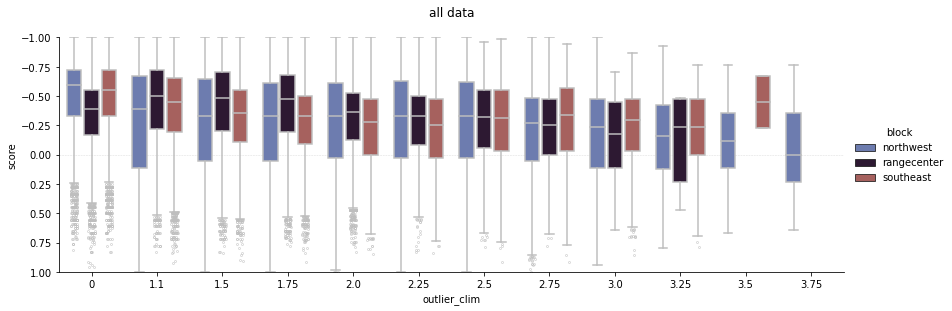

In [32]:
g = sns.catplot(data=validation[validation.block != 'all'],
                x='outlier_clim',
                y='score',
                order=[0, 1.1, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75], #['1.1', '1.25', '1.5', '2.0', '4.0', '6.0', '8.0', '10.0'],
                kind='box',
                hue='block',
                hue_order=['northwest', 'rangecenter', 'southeast'],
                **mvp.boxplot_kwargs,
                height=4,
                aspect=3,
               )

adjust_box_widths(list(g.axes[0]), 0.85)
mvp.jitter_fliers(g)

g.set(ylim=(1, -1), title='all data\n')

for ax in g.axes[0]:
    ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)

plt.show()

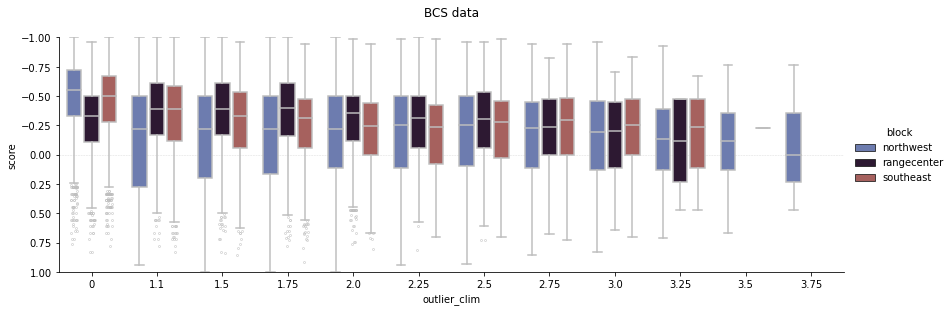

In [33]:
# same but with bcs data and WITH RONA
g = sns.catplot(data=bcs_validation[(bcs_validation.block != 'all')],
                x='outlier_clim',
                y='score',
                order=[0, 1.1, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75], #['1.1', '1.25', '1.5', '2.0', '4.0', '6.0', '8.0', '10.0'],
                kind='box',
                hue='block',
                hue_order=['northwest', 'rangecenter', 'southeast'],
                **mvp.boxplot_kwargs,
                height=4,
                aspect=3,
               )

adjust_box_widths(list(g.axes[0]), 0.85)
mvp.jitter_fliers(g)

g.set(ylim=(1, -1), title='BCS data\n')

for ax in g.axes[0]:
    ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)

plt.show()

In [34]:
# same but with bcs data and WITHOUT RONA
g = sns.catplot(data=bcs_validation[(bcs_validation.block != 'all') & (~bcs_validation.program.str.contains('RONA'))],
                x='outlier_clim',
                y='score',
                order=[0, 1.1, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75], #['1.1', '1.25', '1.5', '2.0', '4.0', '6.0', '8.0', '10.0'],
                kind='box',
                hue='block',
                hue_order=['northwest', 'rangecenter', 'southeast'],
                **mvp.boxplot_kwargs,
                height=4,
                aspect=3,
               )

adjust_box_widths(list(g.axes[0]), 0.85)
mvp.jitter_fliers(g)

g.set(ylim=(1, -1), title='BCS data (without RONA)\n')

for ax in g.axes[0]:
    ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)

plt.show()

### separate programs

In [9]:
for program in validation.program.unique():
    
    vdf = validation[validation.program==program].copy()
    
    g = sns.catplot(data=vdf[vdf.block!='all'],
                    x='outlier_clim',
                    y='score',
                    order=[0, 1.1, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75],
                    kind='box',
                    hue='block',
                    hue_order=['northwest', 'rangecenter', 'southeast'],
                    **mvp.boxplot_kwargs,
                    height=4,
                    aspect=3,
                   )

    adjust_box_widths(list(g.axes[0]), 0.85)
    mvp.jitter_fliers(g)

    g.set(ylim=(1, -1), title=f'{program}\n')

    for ax in g.axes[0]:
        ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)

    plt.show()

# programs side-by-side, 100 pops to validate

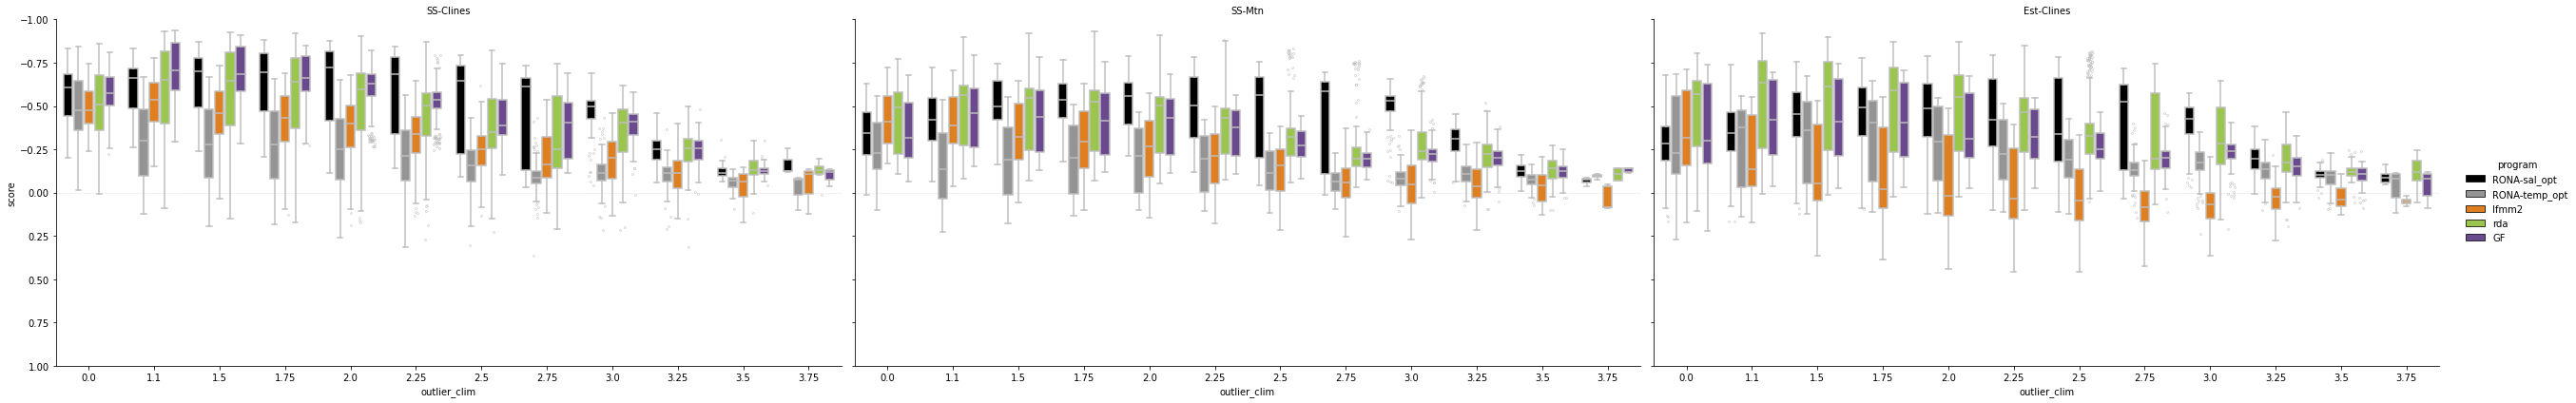

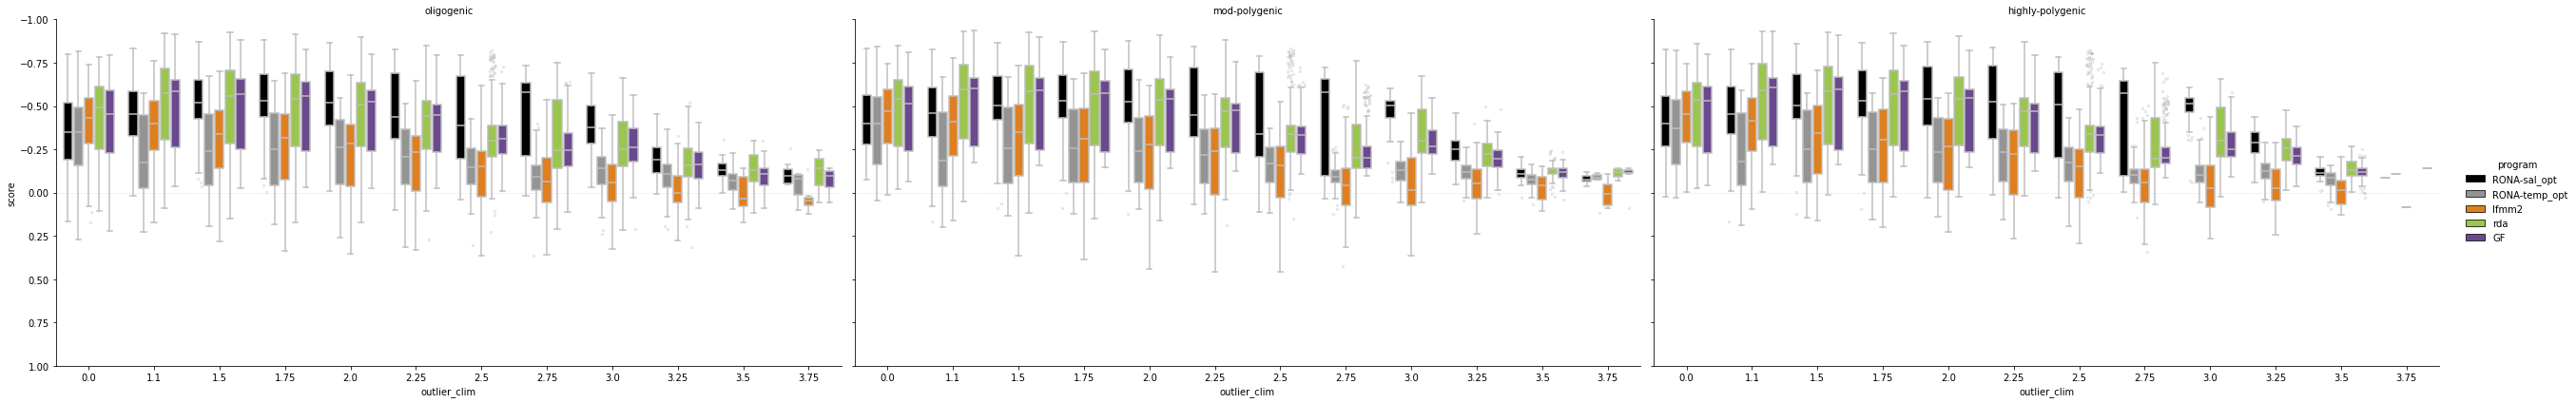

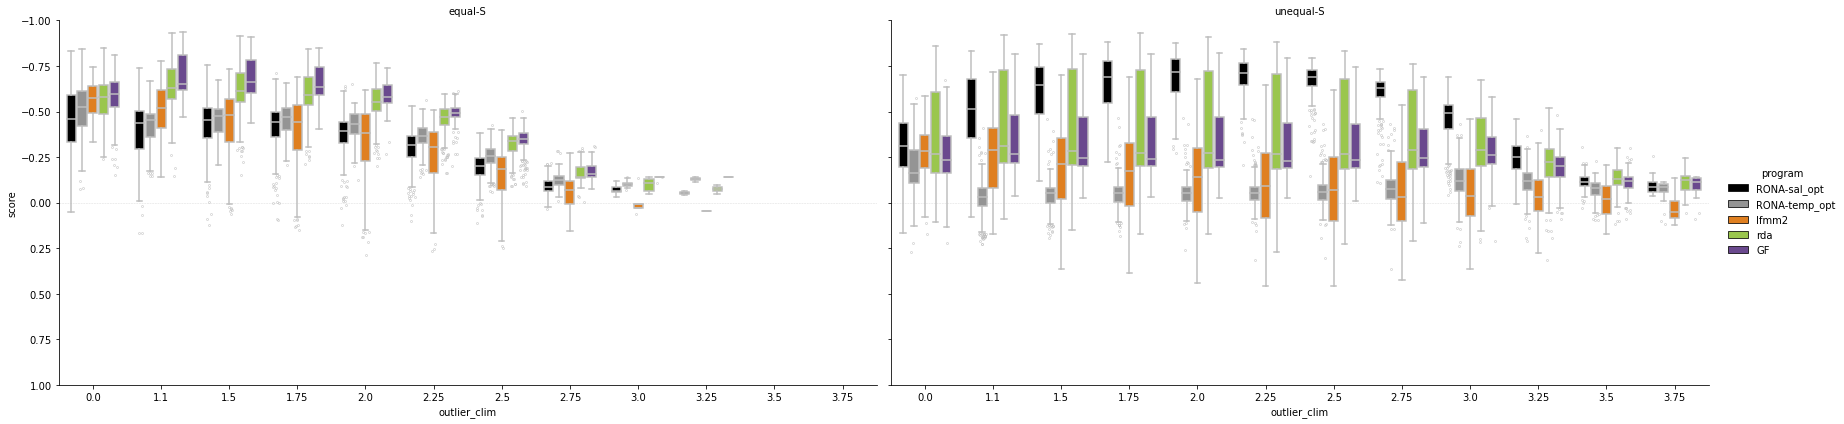

In [10]:
for hue, horder in mvp.hue_order.items():
    if hue == 'noncausal_env' or hue == 'program':
        continue

    g = sns.catplot(data=validation[validation.block=='all'],
                    x='outlier_clim',
                    y='score',
                    order=[0.0, 1.1, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75], #['1.1', '1.25', '1.5', '2.0', '4.0', '6.0', '8.0', '10.0'],
                    kind='box',
                    col=hue,
                    col_order=horder,
                    hue='program',
                    hue_order=mvp.hue_order['program'][1:],
                    **mvp.boxplot_kwargs,
                    height=6,
                    aspect=2,
                   )

    adjust_box_widths(list(g.axes[0]), 0.85)
    mvp.jitter_fliers(g)
    
    g.set_titles('{col_name}')
    
#     g.ax.invert_yaxis()
    g.set(ylim=(1, -1))
    
    for ax in g.axes[0]:
        ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)
        
    plt.show()

# programs side-by-side, block pops to validate

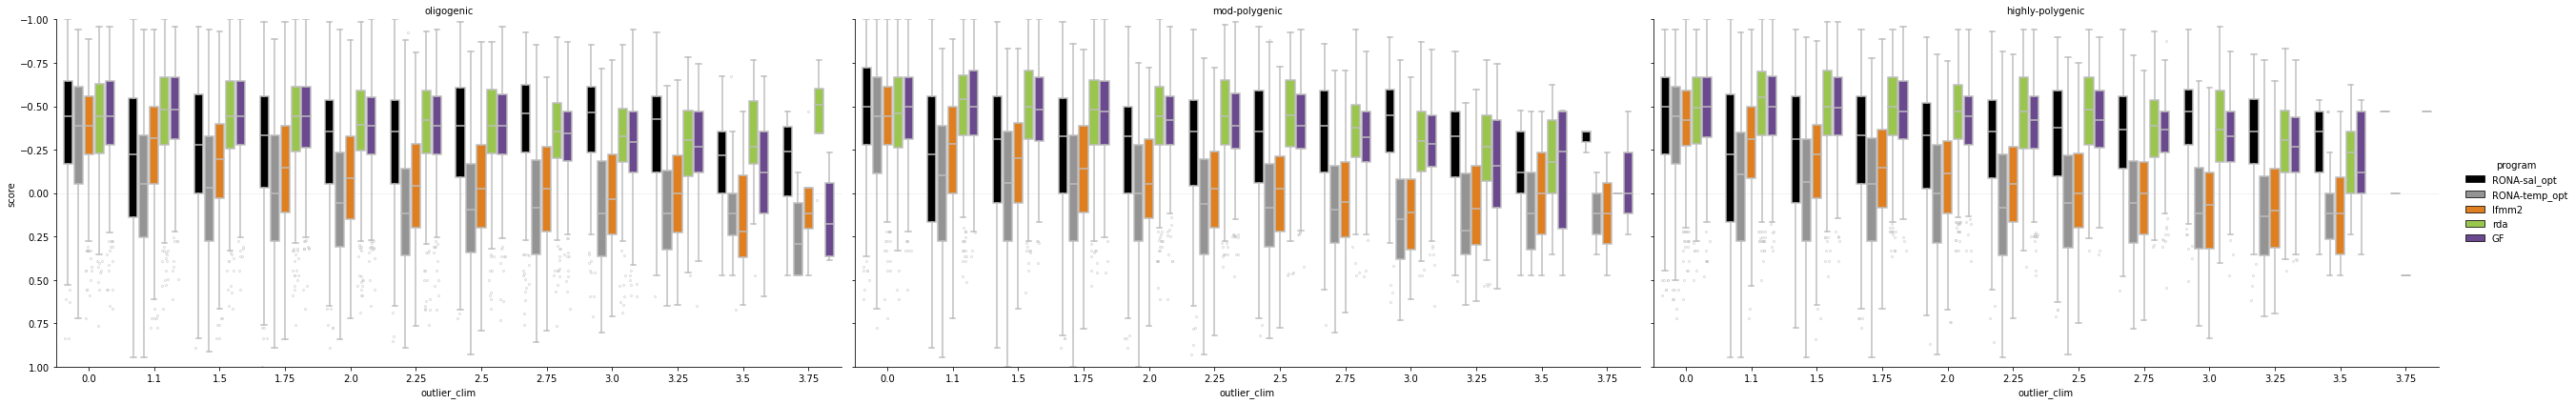

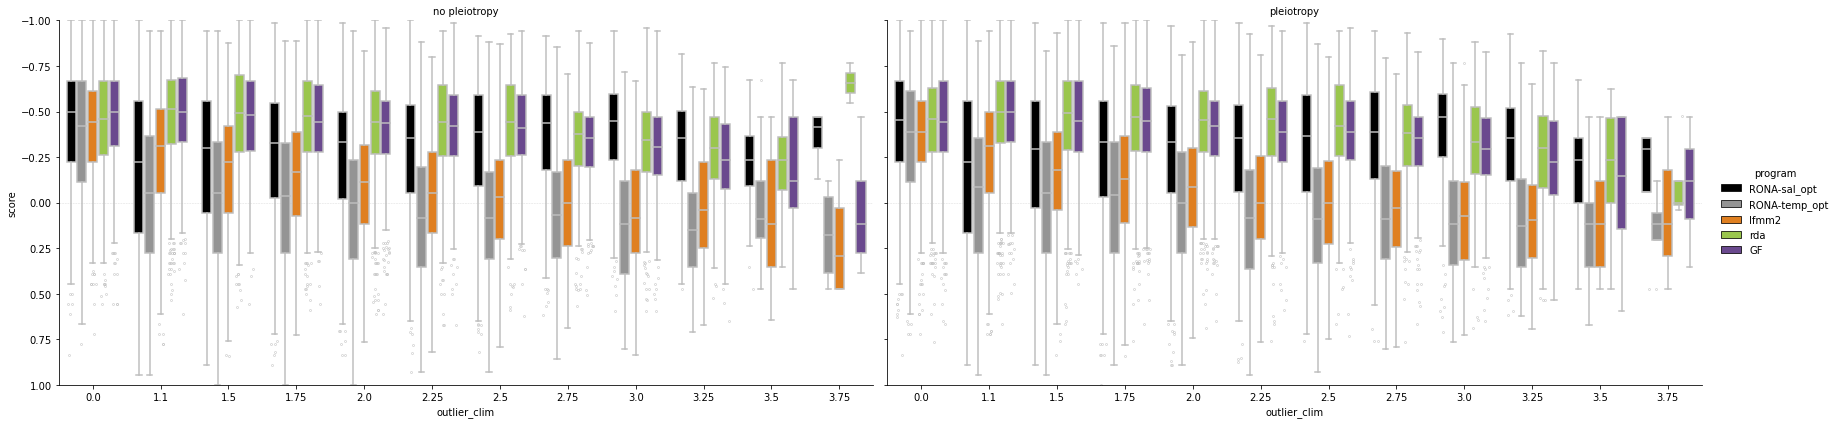

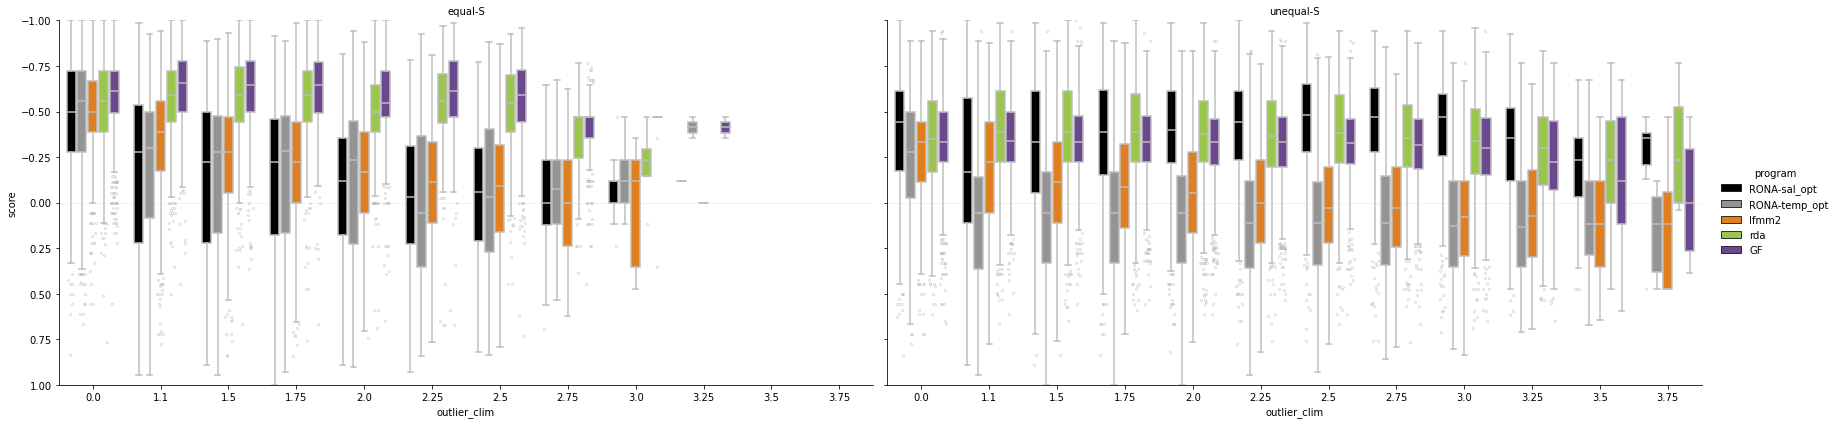

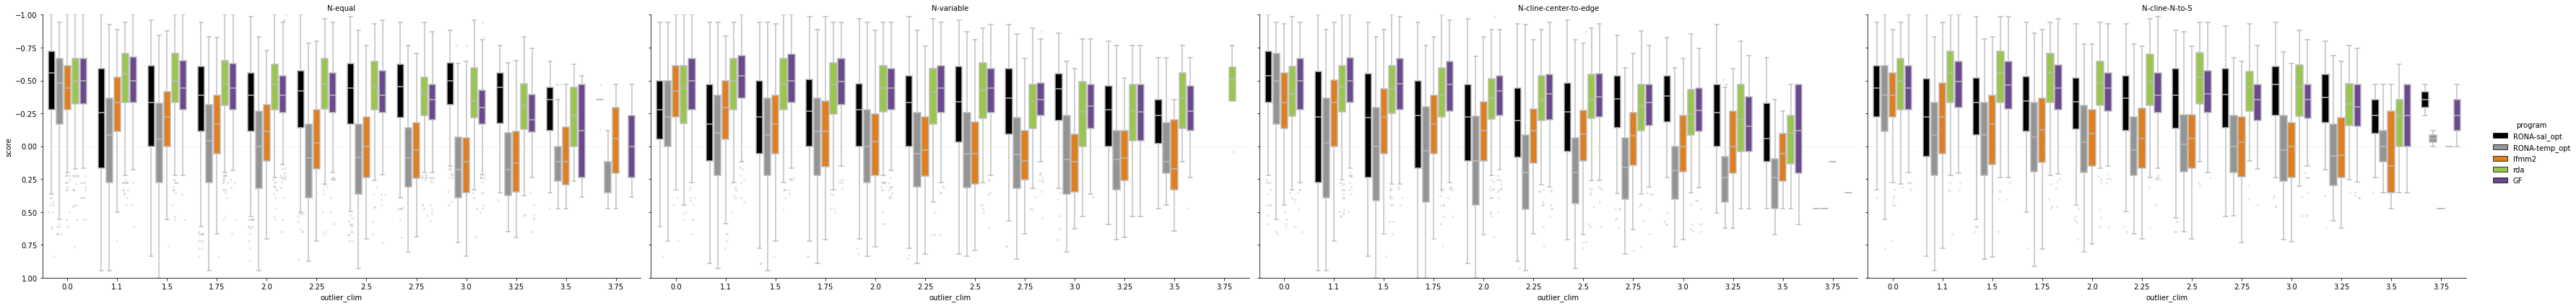

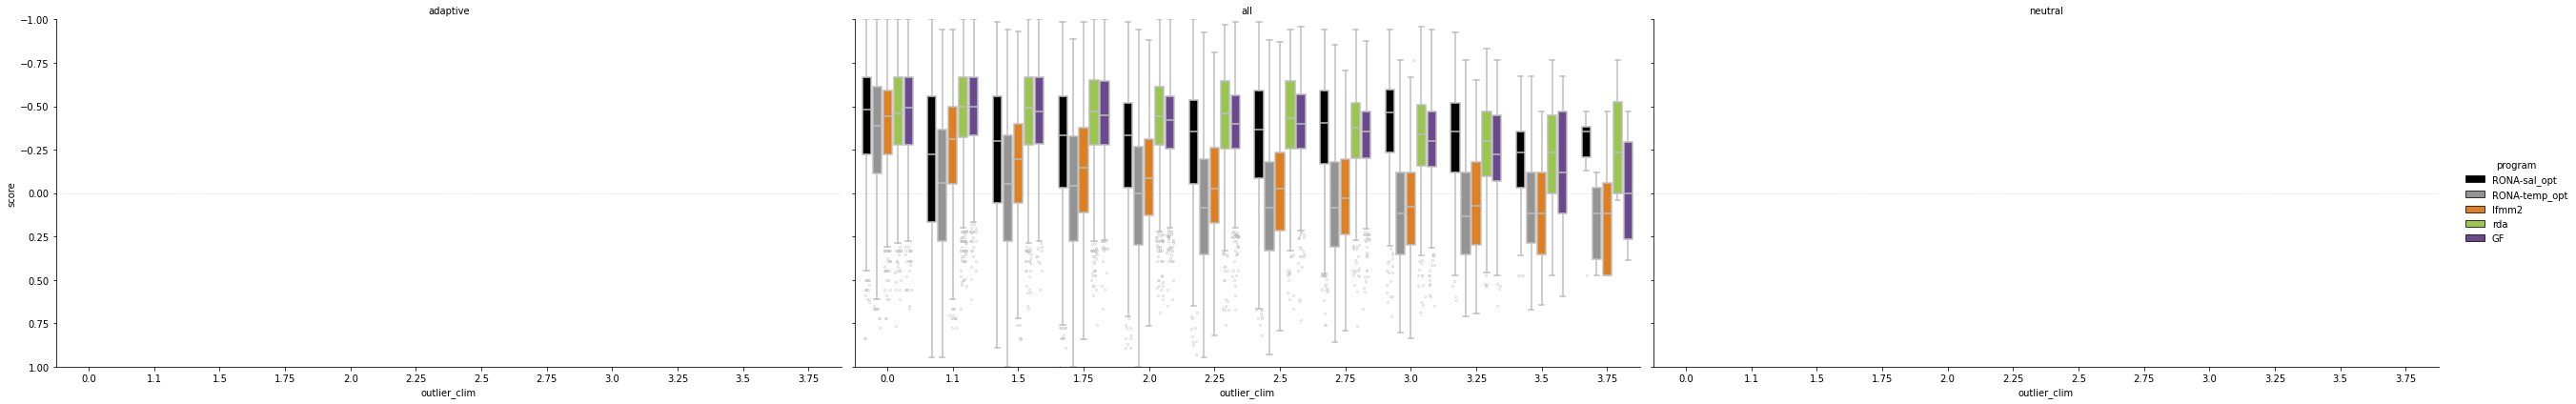

In [11]:
for hue, horder in mvp.hue_order.items():
    if hue == 'noncausal_env' or hue == 'program':
        continue

    g = sns.catplot(data=validation[validation.block!='all'],
                    x='outlier_clim',
                    y='score',
                    order=[0.0, 1.1, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75], #['1.1', '1.25', '1.5', '2.0', '4.0', '6.0', '8.0', '10.0'],
                    kind='box',
                    col=hue,
                    col_order=horder,
                    hue='program',
                    hue_order=mvp.hue_order['program'][1:],
                    **mvp.boxplot_kwargs,
                    height=6,
                    aspect=2,
                   )

    adjust_box_widths(list(g.axes[0]), 0.85)
    mvp.jitter_fliers(g)
    
    g.set_titles('{col_name}')
    
#     g.ax.invert_yaxis()
    g.set(ylim=(1, -1))
    
    for ax in g.axes[0]:
        ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)
        
    plt.show()

# scatter plots as function of local adaptation

In [12]:
# get local adaptation information
summary = mvp.get_summary_data()

validation['final_LA'] = validation.seed.astype(int).astype(str).map(summary['final_LA'].to_dict())

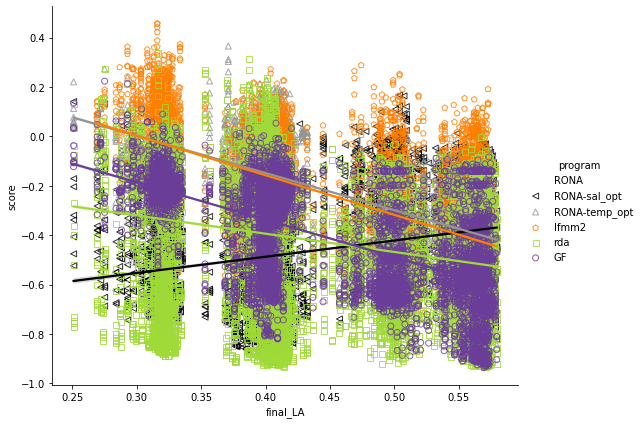

In [13]:
hue = 'program'

g = sns.lmplot(data=validation[validation.block=='all'],
               x='final_LA',
               y='score',
               hue=hue,
               height=6,
               aspect=1.25, 
               hue_order=['RONA', 'RONA-sal_opt', 'RONA-temp_opt', 'lfmm2', 'rda', 'GF'],
               scatter_kws={'facecolor' : 'none'},
               palette=mvp.boxplot_kwargs['palette'],
               markers=pd.Series(mvp.hue_order[hue]).map(mvp.markers).tolist() )

In [14]:
def iterate_outlier_clims(hue, hue_order, markers=None):

    for outlier_clim in validation.outlier_clim.unique():

        # filter the data for best-case scenario
        v = validation[
            (validation.block == 'all') &
            (validation.outlier_clim == outlier_clim)
        ].copy()

        # make sure everything makes sense (each program should have only score per seed)
        for program in v.program.unique():
            df = v[v.program==program]
            print(program, df.seed.value_counts().unique())  # unique counts of all seeds

        g = sns.lmplot(data=v,
                       x='final_LA',
                       y='score',
                       hue=hue,
                       height=6,
                       aspect=1.25, 
                       hue_order=hue_order,
                       scatter_kws={'facecolor' : 'none'},
                       palette=mvp.boxplot_kwargs['palette'],
                       markers=markers)

        g.set(ylim=(0.5, -1), title=f'{outlier_clim = }')

        for ax in g.axes[0]:
            ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)

        plt.show()
    
    pass

GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


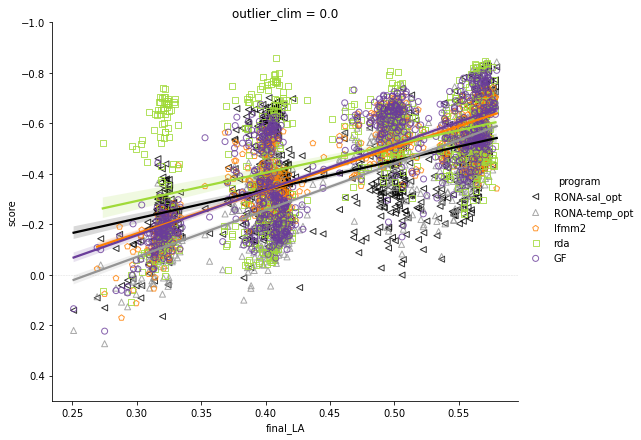

GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


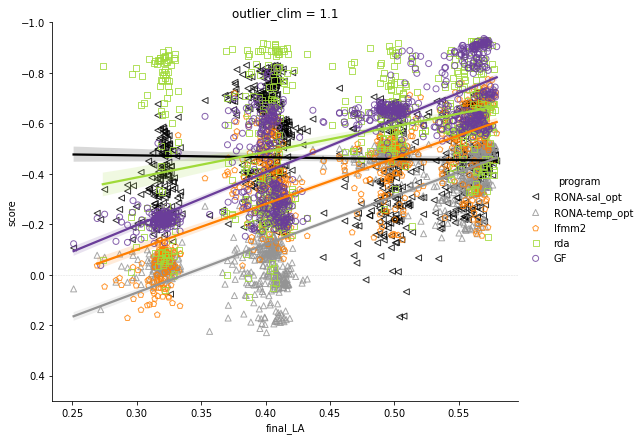

GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


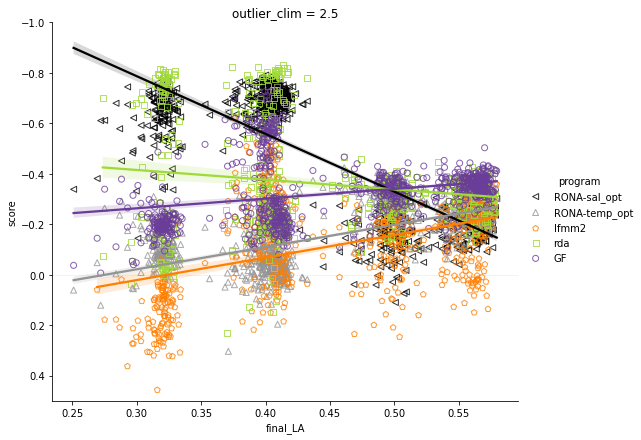

GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


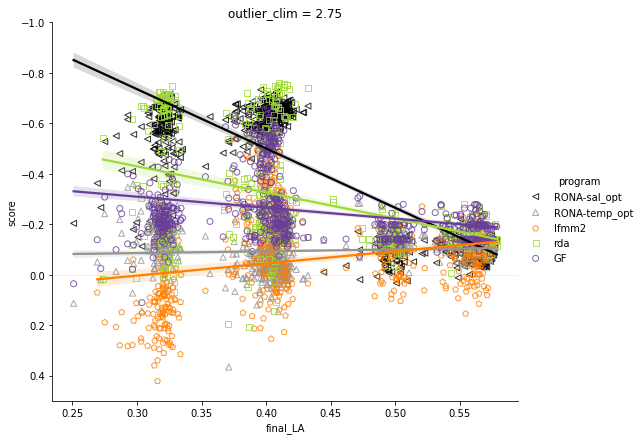

GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


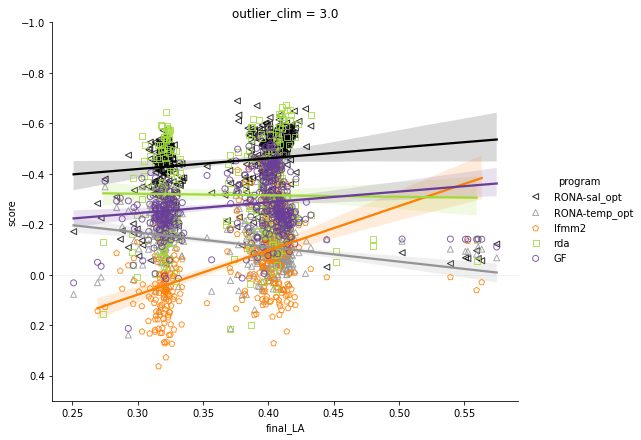

GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


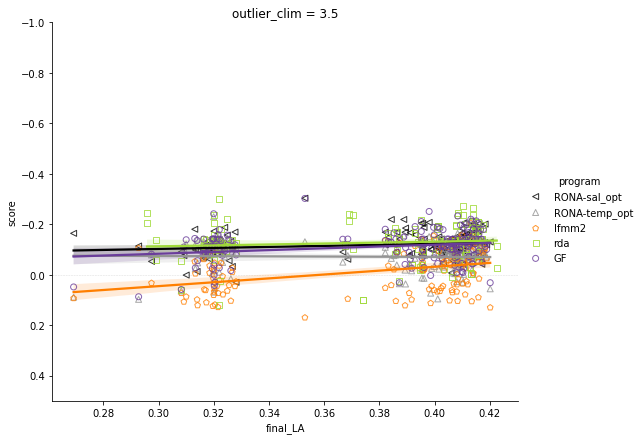

GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


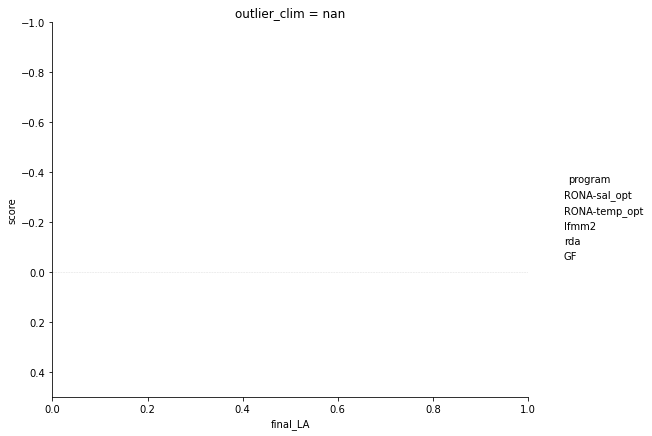

In [15]:
iterate_outlier_clims('program', mvp.hue_order['program'][1:], markers=pd.Series(mvp.hue_order['program'][1:]).map(mvp.markers).tolist())

GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


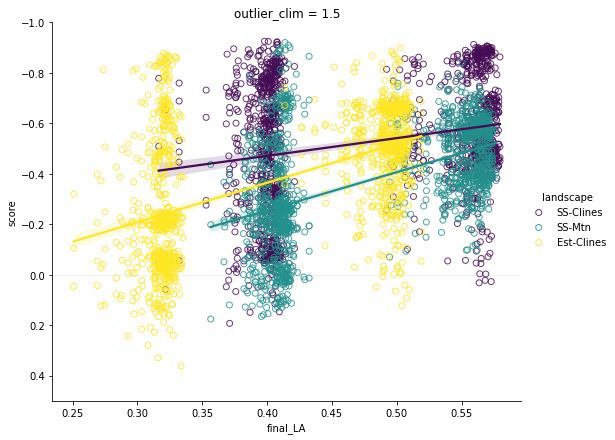

GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


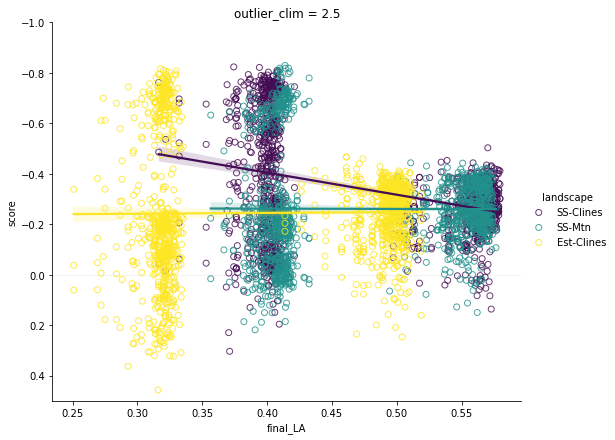

GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


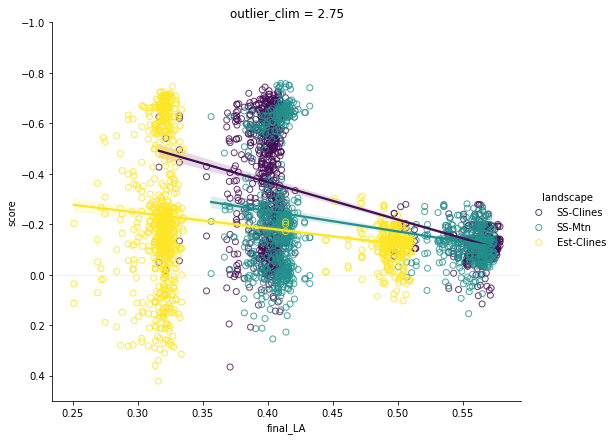

GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


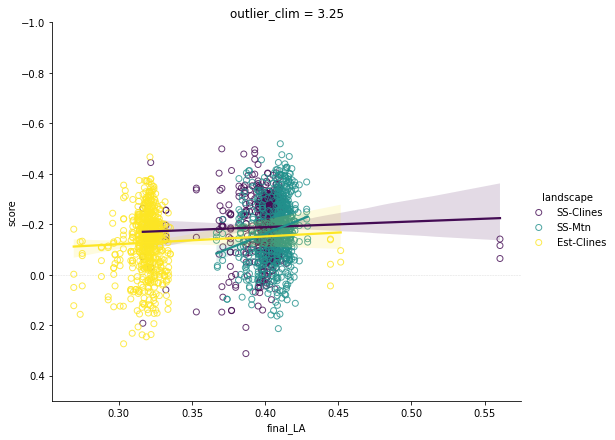

GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


GF [1]
lfmm2 [1]
RONA-sal_opt [1]
RONA-temp_opt [1]
rda [2]


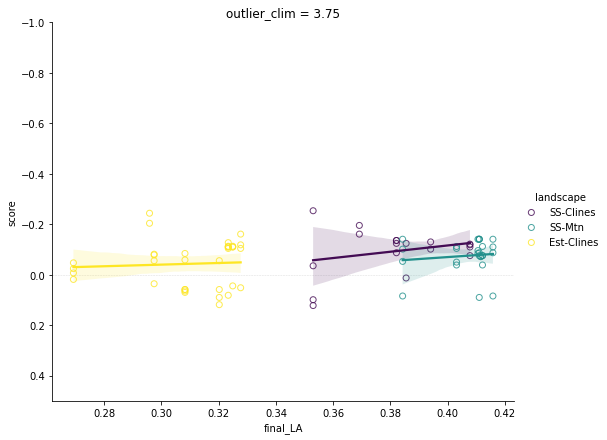

In [16]:
iterate_outlier_clims('landscape', mvp.hue_order['landscape'])

In [17]:
formatclock(dt.now() - t1)

'0-00:01:49'

In [38]:
import MVP_10_train_lfmm2_offset as mvp10

In [39]:
[x for x in dir(mvp10) if 'param' in x]

['read_params_file']

In [45]:
params = mvp10.read_params_file('/home/b.lind/offsets/run_20220919_0-225/slimdir')

params.head()

level  reps  \
1231094  highly-polygenic_1-trait__Est-Clines_N-cline-c...     1   
1231095  highly-polygenic_1-trait__Est-Clines_N-cline-N...     1   
1231096  highly-polygenic_1-trait__Est-Clines_N-equal_m...     1   
1231097  highly-polygenic_1-trait__Est-Clines_N-equal_m...     1   
1231098  highly-polygenic_1-trait__Est-Clines_N-variabl...     1   

                             arch  \
1231094  highly-polygenic_1-trait   
1231095  highly-polygenic_1-trait   
1231096  highly-polygenic_1-trait   
1231097  highly-polygenic_1-trait   
1231098  highly-polygenic_1-trait   

                                           demog_name  \
1231094  Est-Clines_N-cline-center-to-edge_m-constant   
1231095          Est-Clines_N-cline-N-to-S_m-constant   
1231096                   Est-Clines_N-equal_m_breaks   
1231097                 Est-Clines_N-equal_m-constant   
1231098              Est-Clines_N-variable_m-variable   

                           demog_level_sub demog_level  MIG_x  MIG_y  xcline  \
1231094  N-cline-center-to-edge_m-constant  Est-Clines   0.49   0.07  linear   
1231095          N-cline-N-to-S_m-constant  Est-Clines   0.49   0.07  linear   
1231096                   N-equal_m_breaks  Est-Clines   0.49   0.07  linear   
1231097                 N-equal_m-constant  Est-Clines   0.49   0.07  linear   
1231098              N-variable_m-variable  Est-Clines   0.49   0.07  linear   

         ycline    demog  METAPOP_SIDE_x  METAPOP_SIDE_y  Nequal  isVariableM  \
1231094  linear  Estuary              10              10       4            0   
1231095  linear  Estuary              10              10       2            0   
1231096  linear  Estuary              10              10       0            0   
1231097  linear  Estuary              10              10       0            0   
1231098  linear  Estuary              10              10       3            1   

         MIG_breaks arch_level_sub        arch_level       MU_base  \
1231094           0        1-trait  highly-polygenic  1.000000e-07   
1231095           0        1-trait  highly-polygenic  1.000000e-07   
1231096           1        1-trait  highly-polygenic  1.000000e-07   
1231097           0        1-trait  highly-polygenic  1.000000e-07   
1231098           0        1-trait  highly-polygenic  1.000000e-07   

         MU_QTL_proportion  SIGMA_QTN_1  SIGMA_QTN_2  SIGMA_K_1  SIGMA_K_2  \
1231094               0.25        0.002        0.002        0.5        0.5   
1231095               0.25        0.002        0.002        0.5        0.5   
1231096               0.25        0.002        0.002        0.5        0.5   
1231097               0.25        0.002        0.002        0.5        0.5   
1231098               0.25        0.002        0.002        0.5        0.5   

         N_traits  ispleiotropy     seed  
1231094         1             0  1231094  
1231095         1             0  1231095  
1231096         1             0  1231096  
1231097         1             0  1231097  
1231098         1             0  1231098

In [82]:
params.demog_level_sub.unique()

array(['N-cline-center-to-edge_m-constant', 'N-cline-N-to-S_m-constant',
       'N-equal_m_breaks', 'N-equal_m-constant', 'N-variable_m-variable'],
      dtype=object)

In [84]:
params[(params.demog_level_sub == 'N-cline-N-to-S_m-constant') &
       (params.demog_level == 'SS-Clines') &
       (params.N_traits == 2) &
       (params.level.str.contains('-equal-S')) &
       (params.level.str.contains('-no-pleio')) &
       (params.level.str.contains('highly-polygenic'))
      ].iloc[0]['seed']

1231115

In [78]:
dirs = fs('/home/b.lind/offsets', startswith='run_20220919_', dirs=True, exclude=['tutorial', '_old'])
dirs

['/home/b.lind/offsets/run_20220919_0-225',
 '/home/b.lind/offsets/run_20220919_1125-1350',
 '/home/b.lind/offsets/run_20220919_225-450',
 '/home/b.lind/offsets/run_20220919_450-675',
 '/home/b.lind/offsets/run_20220919_675-900',
 '/home/b.lind/offsets/run_20220919_900-1125']

In [89]:
params.loc['1231114', 'level']

'highly-polygenic_2-trait-no-pleiotropy-equal-S__SS-Clines_N-cline-center-to-edge_m-constant'

In [72]:
import MVP_00_start_pipeline as mvp00

In [79]:
for d in dirs:
    seeds = mvp00.get_seeds(op.join(d, 'slimdir'))
    if '1231117' in seeds:
        print(d)

/home/b.lind/offsets/run_20220919_0-225


In [36]:
summary = mvp.get_summary_data()

summary.head()

seed  n_samp_tot  n_samp_per_pop  sd_fitness_among_inds  \
1231094  1231094        1000              10               0.052726   
1231095  1231095        1000              10               0.045199   
1231096  1231096        1000              10               0.053489   
1231097  1231097        1000              10               0.054460   
1231098  1231098        1000              10               0.050930   

         sd_fitness_among_pops  final_LA  K  Bonf_alpha  \
1231094               0.019773  0.500854  2    0.000002   
1231095               0.015411  0.505075  9    0.000002   
1231096               0.020227  0.499265  9    0.000002   
1231097               0.017313  0.499365  9    0.000002   
1231098               0.018326  0.501054  6    0.000006   

         numCausalLowMAFsample  all_corr_phen_temp  subsamp_corr_phen_temp  \
1231094                   39.0            0.954579                0.889339   
1231095                  104.0            0.954576                0.900696   
1231096                   22.0            0.972302                0.887332   
1231097                   24.0            0.972023                0.889530   
1231098                   12.0            0.970856                0.892141   

         all_corr_phen_sal  subsamp_corr_phen_sal  num_causal_prefilter  \
1231094                NaN                    NaN                  2628   
1231095                NaN                    NaN                  3144   
1231096                NaN                    NaN                  3149   
1231097                NaN                    NaN                  3131   
1231098                NaN                    NaN                  1823   

         num_causal_postfilter  num_non_causal  num_neut_prefilter  \
1231094                    310           25753               26587   
1231095                    382           28511               30284   
1231096                    482           32661               33031   
1231097                    470           32187               32548   
1231098                    257            7561                7753   

         num_neut_postfilter  num_neut_neutralgenome  num_causal_temp  \
1231094                26587                   12867              310   
1231095                30284                   14060              382   
1231096                33031                   16379              480   
1231097                32548                   16243              469   
1231098                 7753                    3749              257   

         num_causal_sal  num_multiallelic   meanFst  va_temp_total  \
1231094               0                 0  0.180395       0.011850   
1231095               0                 0  0.169858       0.013437   
1231096               0                 0  0.133961       0.014053   
1231097               0                 0  0.087146       0.013375   
1231098               0                 0  0.318134       0.016054   

         va_sal_total  Va_temp_sample  Va_sal_sample  nSNPs  \
1231094           0.0        0.013565            0.0  26063   
1231095           0.0        0.012768            0.0  28893   
1231096           0.0        0.013705            0.0  33143   
1231097           0.0        0.013051            0.0  32657   
1231098           0.0        0.016230            0.0   7818   

         median_causal_temp_cor  median_causal_sal_cor  median_neut_temp_cor  \
1231094                0.358044                    NaN              0.382053   
1231095                0.413816                    NaN              0.453650   
1231096                0.415703                    NaN              0.402932   
1231097                0.411262                    NaN              0.345151   
1231098                0.392502                    NaN              0.443221   

         median_neut_sal_cor  cor_VA_temp_prop  cor_VA_sal_prop  cor_TPR_temp  \
1231094             0.048169          0.845160              0.0      0.461290   
1231095